In [1]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix,accuracy_score, classification_report,f1_score,cohen_kappa_score

In [2]:
data = pd.read_csv("data_file.csv")

In [3]:
data.head()

Unnamed: 0  label       msisdn    aon  daily_decr30  daily_decr90  \
0           1      0  21408I70789  272.0   3055.050000   3065.150000   
1           2      1  76462I70374  712.0  12122.000000  12124.750000   
2           3      1  17943I70372  535.0   1398.000000   1398.000000   
3           4      1  55773I70781  241.0     21.228000     21.228000   
4           5      1  03813I82730  947.0    150.619333    150.619333   

   rental30  rental90  last_rech_date_ma  last_rech_date_da  ...  \
0    220.13    260.13                2.0                0.0  ...   
1   3691.26   3691.26               20.0                0.0  ...   
2    900.13    900.13                3.0                0.0  ...   
3    159.42    159.42               41.0                0.0  ...   
4   1098.90   1098.90                4.0                0.0  ...   

   maxamnt_loans30  medianamnt_loans30  cnt_loans90  amnt_loans90  \
0              6.0                 0.0          2.0            12   
1             12.0                 0.0          1.0            12   
2              6.0                 0.0          1.0             6   
3              6.0                 0.0          2.0            12   
4              6.0                 0.0          7.0            42   

   maxamnt_loans90  medianamnt_loans90  payback30  payback90  pcircle  \
0                6                 0.0  29.000000  29.000000      UPW   
1               12                 0.0   0.000000   0.000000      UPW   
2                6                 0.0   0.000000   0.000000      UPW   
3                6                 0.0   0.000000   0.000000      UPW   
4                6                 0.0   2.333333   2.333333      UPW   

        pdate  
0  2016-07-20  
1  2016-08-10  
2  2016-08-19  
3  2016-06-06  
4  2016-06-22  

[5 rows x 37 columns]

In [4]:
data.shape

(209593, 37)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            209593 non-null  int64  
 1   label                 209593 non-null  int64  
 2   msisdn                209593 non-null  object 
 3   aon                   209593 non-null  float64
 4   daily_decr30          209593 non-null  float64
 5   daily_decr90          209593 non-null  float64
 6   rental30              209593 non-null  float64
 7   rental90              209593 non-null  float64
 8   last_rech_date_ma     209593 non-null  float64
 9   last_rech_date_da     209593 non-null  float64
 10  last_rech_amt_ma      209593 non-null  int64  
 11  cnt_ma_rech30         209593 non-null  int64  
 12  fr_ma_rech30          209593 non-null  float64
 13  sumamnt_ma_rech30     209593 non-null  float64
 14  medianamnt_ma_rech30  209593 non-null  float64
 15  

# EDA

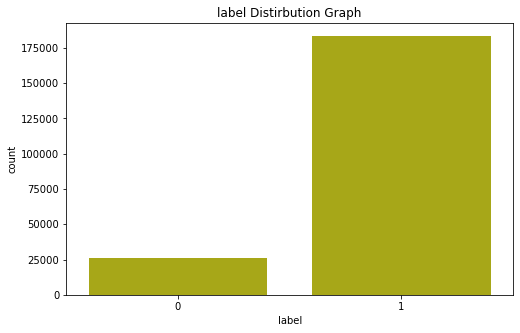

In [6]:
# Distribution of Label
plt.figure(figsize=(8,5))
plt.title("label Distirbution Graph")
ax = sns.countplot(data["label"], color = 'y')

In [7]:
gst = [data]
for i in gst:
    i.loc[(i["rental30"] > 19766) & (i["rental30"] <= 118572), 'balance_criteria'] = 'average balance'
    i.loc[i["rental30"] <= 0,  'balance_criteria'] = 'no balance'
    i.loc[(i["rental30"] > 0) & (i["rental30"] <= 19766), 'balance_criteria'] = 'low balance'
    i.loc[(i["rental30"] > 118572), 'balance_criteria'] = 'high balance'

In [8]:
balance_response_count = pd.crosstab(data['label'],data['balance_criteria']).apply(lambda x: x/x.sum() * 100)
balance_response_count = balance_response_count.transpose()

In [9]:
balance = pd.DataFrame(data['balance_criteria'].value_counts())
balance['Acceptance %'] = balance_response_count[1]
balance.drop('balance_criteria',axis = 1,inplace = True)

balance['balance'] = [0,1,2,3]
balance = balance.sort_values('balance',ascending = True)

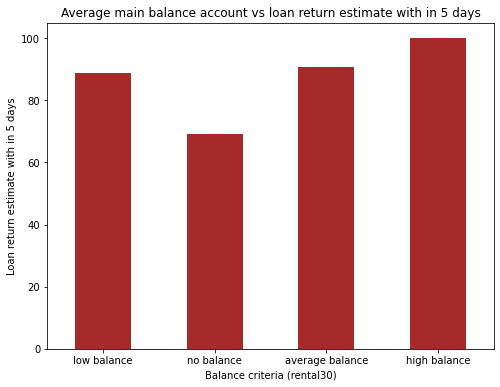

In [10]:
map_ = balance['Acceptance %'].plot(kind = 'bar',color = ('brown'),figsize = (8,6))

plt.title('Average main balance account vs loan return estimate with in 5 days')
plt.ylabel('Loan return estimate with in 5 days')
plt.xlabel('Balance criteria (rental30)')
plt.xticks(rotation = 'horizontal')
plt.show()


The above bar plot tells us how the customers with different main balance levels are paying back the loan with in five days. The high balance level people are with 100% rate i.e they are paying loan within 5 days. Coming to the average and low balance people it is observed that around 10%-12% of people are not paying the loan within 5 days.

Coming to low balance level people, it is observed that around 30% of people are not paying back the loan with in stipulated 5 days of time. The 30% of people with no balance or negative balance people are creating a major loss to the company without paying back the loan within five days of time.

In order to decrease loss to the company, the company should start some marketing strategies like sms alerting and notifications and others on the people with no balance, average and high balance level people notifying them to pay the loan back within five days of time.

In [11]:
gst = [data]
for i in gst:
    i.loc[i["fr_ma_rech30"] <=0,  'frequency_criteria'] = 'no frequency'
    i.loc[(i['fr_ma_rech30'] > 0) & (i['fr_ma_rech30'] <=1 ), 'frequency_criteria'] = 'low frequency'
    i.loc[(i['fr_ma_rech30'] >1) & (i['fr_ma_rech30'] <=2), 'frequency_criteria'] = 'medium frequency'
    i.loc[(i['fr_ma_rech30'] >2), 'frequency_criteria'] = 'high frequency'

In [12]:
frequency_count = pd.crosstab(data['label'],data['frequency_criteria']).apply(lambda x: x/x.sum() * 100)
frequency_count = frequency_count.transpose()

In [13]:
gre = pd.DataFrame(data['frequency_criteria'].value_counts())
gre['Acceptance %'] = frequency_count[1]
gre.drop('frequency_criteria',axis = 1,inplace = True)

gre['frequency'] = [1,2,0,3]
gre= gre.sort_values('frequency',ascending = True)

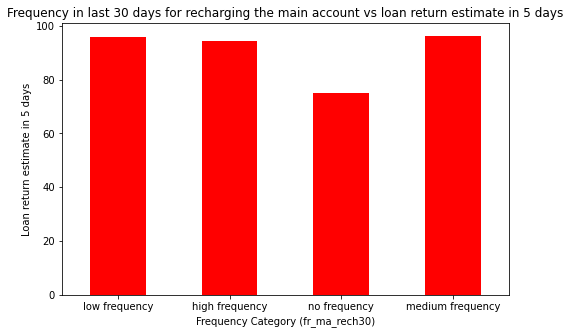

In [75]:
gre_plot = gre['Acceptance %'].plot(kind = 'bar',color = ('red'),figsize = (8,5))

plt.title('Frequency in last 30 days for recharging the main account vs loan return estimate in 5 days')
plt.ylabel('Loan return estimate in 5 days')
plt.xlabel('Frequency Category (fr_ma_rech30)')
plt.xticks(rotation = 'horizontal')
plt.show()

The above bar plot infers us how customers with different frequency levels (main account recharge) are paying back the loan within five days. The is no 100% rate in any of the frequency levels to pay back the loan within 5 days. Coming to the average and low & medium frequency people it is observed that around 5%-6% of people are not paying the loan within 5 days.

Coming to low frequency level people, it is observed that around 25% of people are not paying back the loan with in stipulated 5 days of time. The 25% people who are not getting their main account recharge for 30 days creating a major loss to the company without paying back the loan within five days of time.

In order to decrease loss to the company, the company should start some marketing strategies like sms alerting and notifications and others on the people with all frequency levels and especially on no frequency level people notifying them to pay the loan back within five days of time.

In [15]:
hst = [data]
for i in hst:
    i.loc[i["amnt_loans30"] <=0,  'loan_frequency_group'] = 'No loans'
    i.loc[(i['amnt_loans30'] > 0) & (i['amnt_loans30'] <=6 ), 'loan_frequency_group'] = 'less loans'
    i.loc[(i['amnt_loans30'] >6) & (i['amnt_loans30'] <=24), 'loan_frequency_group'] = 'Avg loans'
    i.loc[(i['amnt_loans30'] >24), 'loan_frequency_group'] = 'High loans'

In [16]:
loan_response = pd.crosstab(data['label'],data['loan_frequency_group']).apply(lambda x: x/x.sum() * 100)
loan_response = loan_response.transpose()

In [17]:
freq = pd.DataFrame(data['loan_frequency_group'].value_counts())
freq['Acceptance %'] = loan_response[1]
freq.drop('loan_frequency_group',axis = 1,inplace = True)

freq['freq'] = [1,2,0,3]
freq= freq.sort_values('freq',ascending = True)

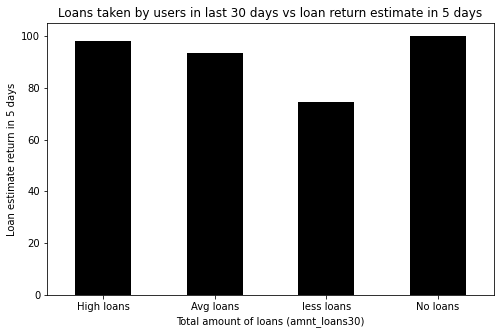

In [76]:
plot_freq = freq['Acceptance %'].plot(kind = 'bar',color = ('black'), figsize = (8,5))

plt.title('Loans taken by users in last 30 days vs loan return estimate in 5 days')
plt.ylabel('Loan estimate return in 5 days')
plt.xlabel('Total amount of loans (amnt_loans30)')
plt.xticks(rotation = 'horizontal')
plt.show()

In [19]:
Correlation_data = data
Corr = Correlation_data.corr().T
Corr

Unnamed: 0     label       aon  daily_decr30  \
Unnamed: 0              1.000000  0.000403 -0.002048      0.002739   
label                   0.000403  1.000000 -0.003785      0.168298   
aon                    -0.002048 -0.003785  1.000000      0.001104   
daily_decr30            0.002739  0.168298  0.001104      1.000000   
daily_decr90            0.003077  0.166150  0.000374      0.977704   
rental30               -0.003906  0.058085 -0.000960      0.442066   
rental90               -0.003459  0.075521 -0.000790      0.458977   
last_rech_date_ma      -0.001853  0.003728  0.001692      0.000487   
last_rech_date_da      -0.001133  0.001711 -0.001693     -0.001636   
last_rech_amt_ma       -0.001064  0.131804  0.004256      0.275837   
cnt_ma_rech30           0.003320  0.237331 -0.003148      0.451385   
fr_ma_rech30            0.003181  0.001330 -0.001163     -0.000577   
sumamnt_ma_rech30       0.000123  0.202828  0.000707      0.636536   
medianamnt_ma_rech30   -0.001371  0.141490  0.004306      0.295356   
medianmarechprebal30    0.001258 -0.004829  0.003930     -0.001153   
cnt_ma_rech90           0.002329  0.236392 -0.002725      0.587338   
fr_ma_rech90           -0.000249  0.084385  0.004401     -0.078299   
sumamnt_ma_rech90       0.000523  0.205793  0.001011      0.762981   
medianamnt_ma_rech90   -0.000298  0.120855  0.004909      0.257847   
medianmarechprebal90   -0.001947  0.039300 -0.000859      0.037495   
cnt_da_rech30           0.000888  0.003827  0.001564      0.000700   
fr_da_rech30           -0.002504 -0.000027  0.000892     -0.001499   
cnt_da_rech90          -0.001324  0.002999  0.001121      0.038814   
fr_da_rech90           -0.002827 -0.005418  0.005395      0.020673   
cnt_loans30             0.001725  0.196283 -0.001826      0.366116   
amnt_loans30            0.002387  0.197272 -0.001726      0.471492   
maxamnt_loans30         0.000698  0.000248 -0.002764     -0.000028   
medianamnt_loans30     -0.002005  0.044589  0.004664     -0.011610   
cnt_loans90             0.002241  0.004733 -0.000611      0.008962   
amnt_loans90            0.000781  0.199788 -0.002319      0.563496   
maxamnt_loans90         0.001742  0.084144 -0.001191      0.400199   
medianamnt_loans90     -0.002615  0.035747  0.002771     -0.037305   
payback30              -0.000040  0.048336  0.001940      0.026915   
payback90               0.002411  0.049183  0.002203      0.047175   

                      daily_decr90  rental30  rental90  last_rech_date_ma  \
Unnamed: 0                0.003077 -0.003906 -0.003459          -0.001853   
label                     0.166150  0.058085  0.075521           0.003728   
aon                       0.000374 -0.000960 -0.000790           0.001692   
daily_decr30              0.977704  0.442066  0.458977           0.000487   
daily_decr90              1.000000  0.434685  0.471730           0.000908   
rental30                  0.434685  1.000000  0.955237          -0.001095   
rental90                  0.471730  0.955237  1.000000          -0.001688   
last_rech_date_ma         0.000908 -0.001095 -0.001688           1.000000   
last_rech_date_da        -0.001886  0.003261  0.002794           0.001790   
last_rech_amt_ma          0.264131  0.127271  0.121416          -0.000147   
cnt_ma_rech30             0.426707  0.233343  0.230260           0.004311   
fr_ma_rech30             -0.000343 -0.001219 -0.000503          -0.001629   
sumamnt_ma_rech30         0.603886  0.272649  0.259709           0.002105   
medianamnt_ma_rech30      0.282960  0.129853  0.120242          -0.001358   
medianmarechprebal30     -0.000746 -0.001415 -0.001237           0.004071   
cnt_ma_rech90             0.593069  0.312118  0.345293           0.004263   
fr_ma_rech90             -0.079530 -0.033530 -0.036524           0.001414   
sumamnt_ma_rech90         0.768817  0.342306  0.360601           0.002243   
medianamnt_ma_rech90      0.250518  0.110356  0.103151          -0.000726   
medianmarechprebal90      0.036

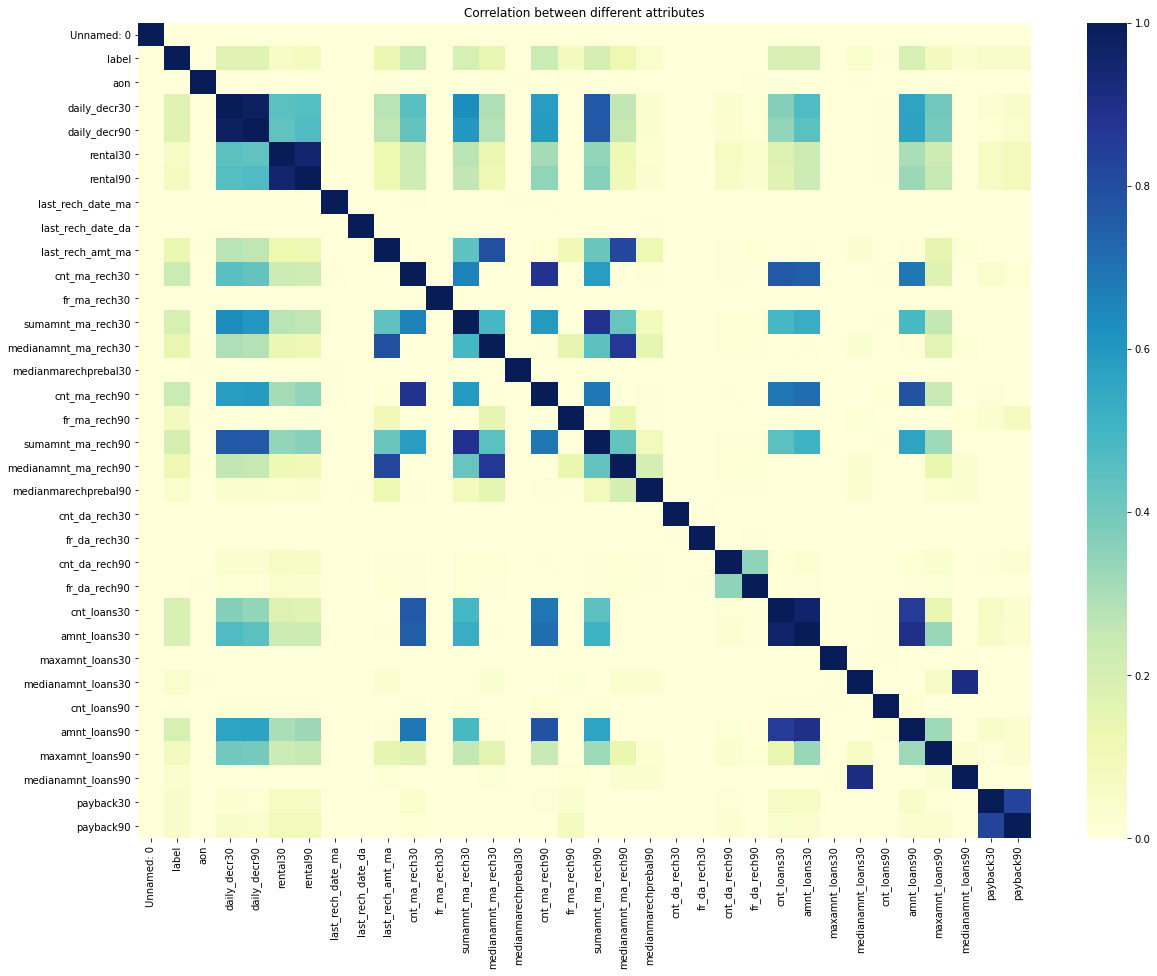

In [20]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(),vmin=0,vmax=1,annot=False,cmap='YlGnBu')
plt.title("Correlation between different attributes")
plt.show()

In [21]:
print(data.corr()["label"].abs().sort_values(ascending=False))

label                   1.000000
cnt_ma_rech30           0.237331
cnt_ma_rech90           0.236392
sumamnt_ma_rech90       0.205793
sumamnt_ma_rech30       0.202828
amnt_loans90            0.199788
amnt_loans30            0.197272
cnt_loans30             0.196283
daily_decr30            0.168298
daily_decr90            0.166150
medianamnt_ma_rech30    0.141490
last_rech_amt_ma        0.131804
medianamnt_ma_rech90    0.120855
fr_ma_rech90            0.084385
maxamnt_loans90         0.084144
rental90                0.075521
rental30                0.058085
payback90               0.049183
payback30               0.048336
medianamnt_loans30      0.044589
medianmarechprebal90    0.039300
medianamnt_loans90      0.035747
fr_da_rech90            0.005418
medianmarechprebal30    0.004829
cnt_loans90             0.004733
cnt_da_rech30           0.003827
aon                     0.003785
last_rech_date_ma       0.003728
cnt_da_rech90           0.002999
last_rech_date_da       0.001711
fr_ma_rech

In [22]:
data.drop(['msisdn', 'pcircle', 'pdate','balance_criteria',
           'frequency_criteria','loan_frequency_group'],axis=1,inplace=True)
data.head()

Unnamed: 0  label    aon  daily_decr30  daily_decr90  rental30  rental90  \
0           1      0  272.0   3055.050000   3065.150000    220.13    260.13   
1           2      1  712.0  12122.000000  12124.750000   3691.26   3691.26   
2           3      1  535.0   1398.000000   1398.000000    900.13    900.13   
3           4      1  241.0     21.228000     21.228000    159.42    159.42   
4           5      1  947.0    150.619333    150.619333   1098.90   1098.90   

   last_rech_date_ma  last_rech_date_da  last_rech_amt_ma  ...  cnt_loans30  \
0                2.0                0.0              1539  ...            2   
1               20.0                0.0              5787  ...            1   
2                3.0                0.0              1539  ...            1   
3               41.0                0.0               947  ...            2   
4                4.0                0.0              2309  ...            7   

   amnt_loans30  maxamnt_loans30  medianamnt_loans30  cnt_loans90  \
0            12              6.0                 0.0          2.0   
1            12             12.0                 0.0          1.0   
2             6              6.0                 0.0          1.0   
3            12              6.0                 0.0          2.0   
4            42              6.0                 0.0          7.0   

   amnt_loans90  maxamnt_loans90  medianamnt_loans90  payback30  payback90  
0            12                6                 0.0  29.000000  29.000000  
1            12               12                 0.0   0.000000   0.000000  
2             6                6                 0.0   0.000000   0.000000  
3            12                6                 0.0   0.000000   0.000000  
4            42                6                 0.0   2.333333   2.333333  

[5 rows x 34 columns]

In [23]:
d8=data.copy()

In [24]:
columns=d8.columns

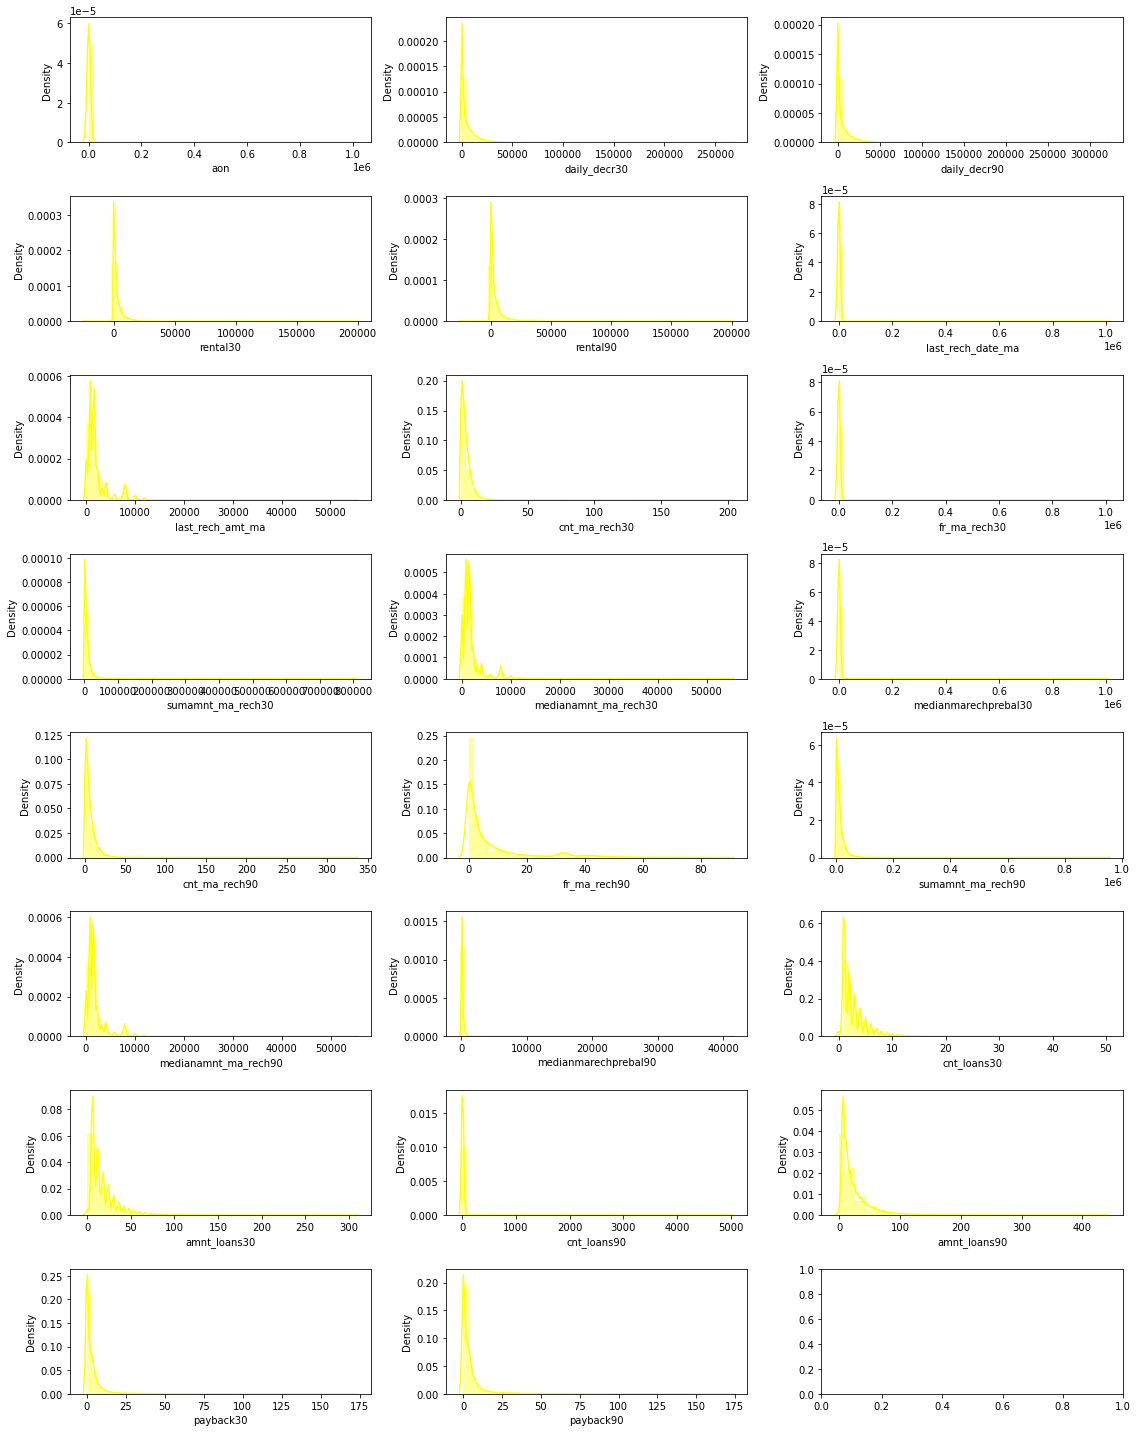

In [25]:
columns=['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_amt_ma', 'cnt_ma_rech30',
       'fr_ma_rech30', 'sumamnt_ma_rech30', 'medianamnt_ma_rech30',
       'medianmarechprebal30', 'cnt_ma_rech90', 'fr_ma_rech90',
       'sumamnt_ma_rech90', 'medianamnt_ma_rech90', 'medianmarechprebal90',
       'cnt_loans30', 'amnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'payback30', 'payback90']
fig,ax = plt.subplots(8,3,figsize=(16,20))
ax = ax.flatten()
for i,col in enumerate(columns):
    sns.distplot(d8[col],ax=ax[i],color='yellow')
plt.tight_layout()
plt.show()

In [26]:
d6 = data.copy()

Several changes were made to the dataset to prepare it for analysis. As there are no null values in the data set there is no need to perform any null value imputation for the data set. There are outliers for many variables in the data set.

By observing these features, I found way of doing an outlier’s imputation technique for the data of the features whose z-score >3. There are many ways to deal with outliers such as imputing outlier’s with mean, median, mode (categorical), k-NN imputation, mice imputation or simply removing and others.



# STATISTICAL ANALYSIS

In [27]:
columns=['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_date_da', 'last_rech_amt_ma',
       'cnt_ma_rech30', 'fr_ma_rech30', 'sumamnt_ma_rech30',
       'medianamnt_ma_rech30', 'medianmarechprebal30', 'cnt_ma_rech90',
       'fr_ma_rech90', 'sumamnt_ma_rech90', 'medianamnt_ma_rech90',
       'medianmarechprebal90', 'cnt_da_rech30', 'fr_da_rech30',
       'cnt_da_rech90', 'fr_da_rech90', 'cnt_loans30', 'amnt_loans30',
       'maxamnt_loans30', 'medianamnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'maxamnt_loans90', 'medianamnt_loans90', 'payback30', 'payback90']
for i in range(len(columns)):
    d6[columns[i]]=zscore(d6[columns[i]])
    for j in range(len(d6[columns[i]])):
        if d6[columns[i]][j]>3 or d6[columns[i]][j]<-3:
            d6[columns[i]].replace(d6[columns[i]][j],d6[columns[i]].median(),inplace=True)
    d6[columns[i]]=np.cbrt((d6[columns[i]]))

In [28]:
d6.drop(['label'],axis=1,inplace=True)

In [71]:
def sample_test(target, column):
    Reject = []
    Accept = []
    print('H0: The mean of ' + column.name + ' is equal for both categories of ' + target.name)
    print('H1: The mean of ' + column.name + ' is NOT equal for both categories of ' + target.name)
    print()
    group0 = column[target == 0]
    group1 = column[target == 1]
    t_test = stats.ttest_ind(group0, group1)
    print(t_test)
    RejectH0 = t_test[1] < 0.05
    print()
    if RejectH0:
        print('Rejected H0')
        Reject.append(col)
        print('\n')
        print('-------------------------------------------------------------------------')
    else:
        print('Did not Reject H0')   
        Accept.append(col)
        print()
        print('-------------------------------------------------------------------------')

In [72]:
num_cols = ['aon', 'daily_decr30', 'daily_decr90', 'rental30', 'rental90',
       'last_rech_date_ma', 'last_rech_date_da', 'last_rech_amt_ma',
       'cnt_ma_rech30', 'fr_ma_rech30', 'sumamnt_ma_rech30',
       'medianamnt_ma_rech30', 'medianmarechprebal30', 'cnt_ma_rech90',
       'fr_ma_rech90', 'sumamnt_ma_rech90', 'medianamnt_ma_rech90',
       'medianmarechprebal90', 'cnt_da_rech30', 'fr_da_rech30',
       'cnt_da_rech90', 'fr_da_rech90', 'cnt_loans30', 'amnt_loans30',
       'maxamnt_loans30', 'medianamnt_loans30', 'cnt_loans90', 'amnt_loans90',
       'maxamnt_loans90', 'medianamnt_loans90', 'payback30', 'payback90']

for col in num_cols:
    rejectH0 = sample_test(data['label'], d6[col])

H0: The mean of aon is equal for both categories of label
H1: The mean of aon is NOT equal for both categories of label

Ttest_indResult(statistic=-35.67290016772076, pvalue=7.146659627787853e-278)

Rejected H0


-------------------------------------------------------------------------
H0: The mean of daily_decr30 is equal for both categories of label
H1: The mean of daily_decr30 is NOT equal for both categories of label

Ttest_indResult(statistic=-95.92326407287548, pvalue=0.0)

Rejected H0


-------------------------------------------------------------------------
H0: The mean of daily_decr90 is equal for both categories of label
H1: The mean of daily_decr90 is NOT equal for both categories of label

Ttest_indResult(statistic=-95.84733435012987, pvalue=0.0)

Rejected H0


-------------------------------------------------------------------------
H0: The mean of rental30 is equal for both categories of label
H1: The mean of rental30 is NOT equal for both categories of label

Ttest_indR

In [54]:
cov_matrx = np.cov(d6.T)
print('Covariance Matrix \n%s', cov_matrx)

Covariance Matrix 
%s [[ 3.66078627e+09  5.23376093e-01  1.05747984e+02 ... -6.39765700e+01
  -1.07595313e+01  2.02122393e+01]
 [ 5.23376093e-01  1.10530498e-04  5.96454189e-04 ... -4.78234527e-06
   1.28083927e-04  2.12521954e-04]
 [ 1.05747984e+02  5.96454189e-04  5.63641611e-01 ... -5.15869914e-03
   8.82617731e-02  8.98069755e-02]
 ...
 [-6.39765700e+01 -4.78234527e-06 -5.15869914e-03 ...  9.75001146e-02
  -2.13322228e-03  1.83662697e-03]
 [-1.07595313e+01  1.28083927e-04  8.82617731e-02 ... -2.13322228e-03
   3.82551451e-01  3.02046363e-01]
 [ 2.02122393e+01  2.12521954e-04  8.98069755e-02 ...  1.83662697e-03
   3.02046363e-01  3.81340038e-01]]


In [33]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrx)
eigen_pairs = [(np.abs(eig_vals[i]), eig_vecs[ :, i]) for i in range(len(eig_vals))]

In [35]:
total = sum(eig_vals)
variable_exp = [( i /total ) * 100 for i in sorted(eig_vals, reverse=True)]
cum_variable_exp = np.cumsum(variable_exp)
print("Cumulative Variance Explained", cum_variable_exp)

Cumulative Variance Explained [ 99.99999972  99.99999982  99.99999987  99.99999989  99.99999991
  99.99999993  99.99999994  99.99999995  99.99999996  99.99999997
  99.99999997  99.99999998  99.99999998  99.99999999  99.99999999
  99.99999999  99.99999999  99.99999999 100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.        ]


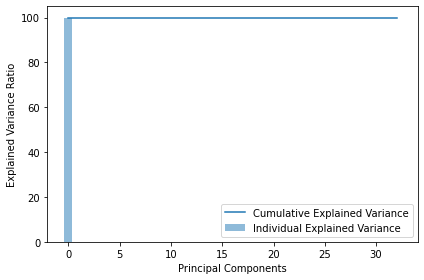

In [37]:
plt.figure(figsize=(6 , 4))
plt.bar(range(33), variable_exp, alpha = 0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(33), cum_variable_exp, where='mid', label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=13)
pca.fit(d6)
data_pca = pd.DataFrame(pca.transform(d6))
data_pca.shape

(209593, 13)

In [47]:
X2=data_pca
y2=data['label']

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(146715, 13)
(62878, 13)
(146715,)
(62878,)


# LOGISTIC REGRESSION

In [49]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [50]:
print('Training score =', model.score(X_train, y_train))
print('Test score =', model.score(X_test, y_test))

Training score = 0.8761067375523975
Test score = 0.8778109990775788


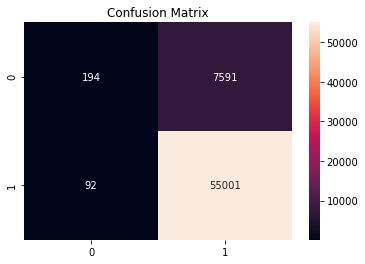

In [51]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

ROC AUC = 0.8302235744286699


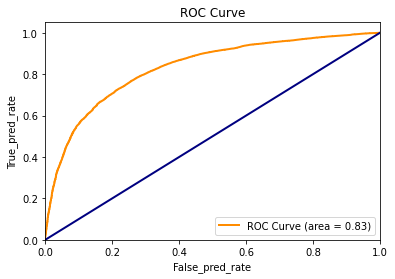

In [52]:
from sklearn.metrics import roc_curve,roc_auc_score
y_pred = model.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test,y_pred[:,1])
roc_auc = roc_auc_score(y_test,y_pred[:,1])

print('ROC AUC =', roc_auc)
plt.figure()
lw = 2
plt.plot(fpr,tpr,color='darkorange',lw=lw,label='ROC Curve (area = %0.2f)'%roc_auc)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False_pred_rate')
plt.ylabel('True_pred_rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [56]:
TN = cm[0,0]  #True Negative
TP = cm[1,1]  #True Positives
FP = cm[0,1]  #False Positives
FN = cm[1,0]  #False Negatives

ACCURACY = (TP+TN)/(TP+FN+FP+TN)
PRECISION = TP / (TP+FP)
RECALL = TP / (TP+FN)
F1 = 2*PRECISION*RECALL / (PRECISION+RECALL)

print('Accuracy =',ACCURACY)
print('Precision =', PRECISION)
print('Recall =', RECALL)
print('F1 Score =', F1)

Accuracy = 0.8778109990775788
Precision = 0.8787225204498977
Recall = 0.9983300963824805
F1 Score = 0.9347155542337595


In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# KNN

In [58]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
knn=KNeighborsClassifier()
param={'n_neighbors':np.arange(5,30),'weights':['uniform','distance']}
GS=RandomizedSearchCV(knn,param,cv=3,scoring='f1_weighted',n_jobs=-1)
GS.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29]),
                                        'weights': ['uniform', 'distance']},
                   scoring='f1_weighted')

In [59]:
GS.best_params_

{'weights': 'distance', 'n_neighbors': 11}

In [60]:
KNN=KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN.fit(X_train,y_train)
y_pred2 = KNN.predict(X_test)

In [61]:
print('Training score =', KNN.score(X_train, y_train))
print('Test score =', KNN.score(X_test, y_test))

Training score = 1.0
Test score = 0.8570247145265435


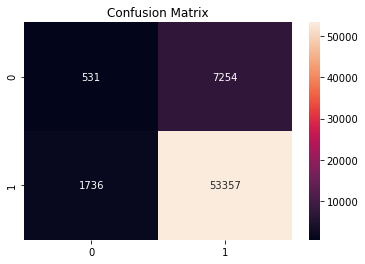

In [62]:
from sklearn.metrics import confusion_matrix
y_pred2 = KNN.predict(X_test)
cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [64]:
TN = cm2[0,0]  #True Negative
TP = cm2[1,1]  #True Positives
FP = cm2[0,1]  #False Positives
FN = cm2[1,0]  #False Negatives

ACC = (TP+TN)/(TP+FN+FP+TN)
PRE = TP / (TP+FP)
RECALL = TP / (TP+FN)
F1 = 2*PRE*RECALL / (PRE+RECALL)

print('Accuracy =',ACC)
print('Precision =', PRE)
print('Recall =', RECALL)
print('F1 Score =', F1)

Accuracy = 0.8570247145265435
Precision = 0.8803187540215472
Recall = 0.9684896447824588
F1 Score = 0.9223017354629053


# DECISION TREE

In [65]:
dt=DecisionTreeClassifier(random_state=0)
param={'max_depth':np.arange(3,50),'criterion':['entropy','gini'],'min_samples_leaf':np.arange(3,20)}
GS=RandomizedSearchCV(dt,param,cv=3,scoring='f1_weighted')
GS.fit(X_train,y_train)
GS.best_params_

{'min_samples_leaf': 18, 'max_depth': 28, 'criterion': 'gini'}

In [66]:
DT=DecisionTreeClassifier(criterion='entropy',max_depth=14,min_samples_leaf=19,random_state=0)
DT.fit(X_train,y_train)
y_pred1=DT.predict(X_test)

In [67]:
print('Training score =', DT.score(X_train, y_train))
print('Test score =', DT.score(X_test, y_test))

Training score = 0.901243908257506
Test score = 0.8881325741912911


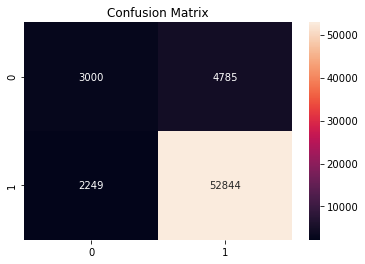

In [68]:
from sklearn.metrics import confusion_matrix
y_pred1 = DT.predict(X_test)
cm1 = confusion_matrix(y_test, y_pred1)
sns.heatmap(cm1, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [69]:
TN = cm1[0,0]  #True Negative
TP = cm1[1,1]  #True Positives
FP = cm1[0,1]  #False Positives
FN = cm1[1,0]  #False Negatives

ACC = (TP+TN)/(TP+FN+FP+TN)
PRE = TP / (TP+FP)
RECALL = TP / (TP+FN)
F1 = 2*PRE*RECALL / (PRE+RECALL)

print('Accuracy =',ACC)
print('Precision =', PRE)
print('Recall =', RECALL)
print('F1 Score =', F1)

Accuracy = 0.8881325741912911
Precision = 0.9169688871922123
Recall = 0.9591781170021599
F1 Score = 0.9375986941324674


In [85]:
import joblib
joblib.dump(model,'telecom.pkl')

['telecom.pkl']